[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github//ragatti/STSnet/blob/master/evaluate.ipynb) 

[![View source on GitHub!](https://badgen.net/badge/icon/View%20on%20Github?icon=github&label)](https://github.com/ragatti/STSnet/blob/master/evaluate.ipynb)

In [ ]:
# Authors: Ramiro Gatti <rgatti@ingenieria.uner.edu.ar>

In [ ]:
%cd /content/
!git clone https://github.com/ragatti/moabb.git
%cd moabb/
!pip install -r requirements.txt
!python setup.py develop
%cd ..
!git clone https://github.com/ragatti/STSnet.git
%cd STSnet/
!pip install -r requirements.txt
# !pip install tensorflow==1.11.0

In [2]:
%matplotlib inline
import random
from stsnet.datasets import PGHealthy
from stsnet.utils import best_model_file, eval_metrics
from moabb.paradigms import MotorImagery, FilterBankMotorImagery
from moabb.evaluations import WithinSessionEvaluation
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import make_pipeline
from moabb.pipelines.utils import FilterBank
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from stsnet.models import STSnet
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import (ModelCheckpoint,
                                        EarlyStopping)
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
import sklearn
import mne
import moabb
moabb.set_log_level('info')
print(tf.__version__)

Set data format to channels_first
1.11.0


In [3]:
# Reproducibility
SEED = 7
random.seed(SEED)
np.random.seed(SEED)
tf.set_random_seed(SEED)

In [4]:
# Load data

# from google.colab import drive
# drive.mount('/content/gdrive') # Folder to data in google drive

DATA_DIR = '../datasets/Palmar grasp/Motor execution - healthy'
dspg = PGHealthy()
dspg.set_path(DATA_DIR)

In [5]:
# Paradigm
n_clss = 4
fs = 500
fmin, fmax = None, None
tmin, tmax = 3 - 0.6, 3 - 0.102
chans = ['F5', 'F3', 'F1', 'Fz', 'FC5', 'FC3', 'FC1', 
         'FCz', 'C5', 'C3', 'C1', 'Cz', 'CP5', 'CP3',
         'CP1', 'CPz', 'P5', 'P3', 'P1', 'Pz']
ch_rows, ch_cols = 5, 4 
paradigm = MotorImagery(n_classes=n_clss, fmin=fmin, fmax=fmax,
                        tmin=tmin, tmax=tmax, channels=chans,
                        baseline=(-1, 0))   

2020-09-09 21:53:49 ramiro-LIRINS root[3373] WARNING Choosing from all possible events


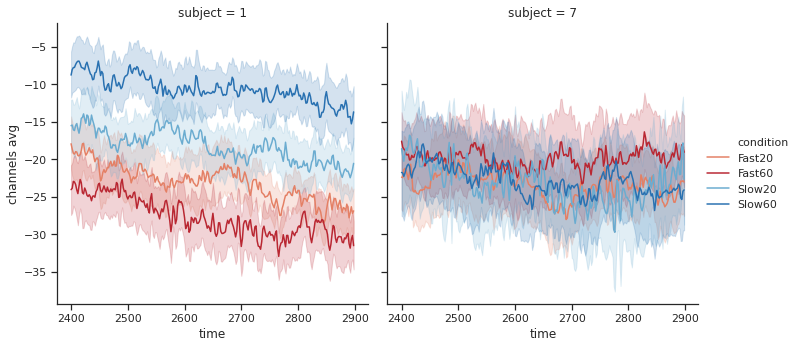

In [6]:
# Visualization
sns.set(style="ticks")
label_color = [ "#e48065", "#b92732", "#6bacd0", "#2971b1"]
sns.set_palette(sns.color_palette(label_color))
data = pd.DataFrame()
for sbj in [1, 7]:
    X, y, meta = paradigm.get_data(dataset=dspg, subjects=[sbj],
                                   return_epochs=True)
    epochs = mne.concatenate_epochs(X, add_offset=False)

    df = epochs.to_data_frame()
    df['channels avg'] = col = df.loc[: , chans].mean(axis=1)
    df['subject'] =sbj
    data = pd.concat([data, df])
data.head()
sns.relplot(data=data, x='time', y='channels avg', col='subject',
                 hue='condition', kind='line', n_boot=5000)

In [7]:
# Load model
samples = X[0].get_data().shape[2]
BATCHS = 16
EPOCHS = 500
model = STSnet(n_clss= n_clss, ch_rows=ch_rows, kernLength=64,
               ch_cols=ch_cols, samples=samples)
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['acc'])
model.summary()

# Save model
out_path = os.path.join(os.getcwd(),'results', 'Test1')
os.makedirs(out_path, exist_ok=True)
model_path = os.path.join(out_path, 'model.h5')
model.save(model_path)
del model

kernel_length 64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 20, 250)           0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 20, 250)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 20, 250)        256       
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 20, 250)        16        
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 5, 4, 250)      0         
_________________________________________________________________
permute (Permute)            (None, 250, 4, 5, 4)      0         
_________________________________________________________________
time_distributed (TimeDistri (None, 250, 8, 1, 1)      160 

In [8]:
# Train
kfold = StratifiedShuffleSplit(5, test_size=32, train_size=128, random_state=1)
results = list()
for sbj in dspg.subject_list:
    print('\nSubject: ', sbj)
    # Get data
    X, y, meta = paradigm.get_data(dataset=dspg, subjects=[sbj])
    le = LabelEncoder()
    y = le.fit_transform(y)
    cat_y = to_categorical(y, n_clss)

    print()
    title = 'Subject ' + str(sbj)
    subject_path = os.path.join(out_path, 'model_checkpoints', title)
    os.makedirs(subject_path, exist_ok=True)
    
    for cv, (train, test) in enumerate(kfold.split(X, y)):
        print('train -  {}   |   test -  {}'.format(
        train.shape[0], test.shape[0]))
        model = load_model(model_path)

        file = 'Model_cv{}-epoch_{{epoch:02d}}-val_loss_{{val_loss:.3f}}.hdf5'
        file_path = os.path.join(subject_path, file.format(cv))
        
        checkpointer = ModelCheckpoint(filepath=file_path, monitor='val_loss',
                                       verbose=0, save_best_only=True)

        earlystopper = EarlyStopping(monitor='val_loss', min_delta=0,
                                     patience=50, verbose=1, mode='min')

        history = model.fit(X[train], cat_y[train],
                            batch_size=BATCHS, epochs=EPOCHS, verbose=0,
                            validation_split=0.2, shuffle=True,
                            callbacks=[earlystopper, checkpointer])

        # Evaluate
        best_model = best_model_file(history, cv)
        best_model_path = os.path.join(subject_path, best_model)
        model = load_model(best_model_path)
        pred = model.predict(X[test],verbose=0)
        acc, kappa = eval_metrics(y[test], pred.argmax(axis=-1))
        results.append({'subject': sbj,
                        'fold': cv,
                        'acc': acc,
                        'kappa': kappa})
results = pd.DataFrame(results)
results.to_csv(os.path.join(out_path,'results.csv'), index=False)


Subject:  1

train -  128   |   test -  32
Epoch 00259: early stopping
train -  128   |   test -  32
Epoch 00184: early stopping
train -  128   |   test -  32
Epoch 00300: early stopping
train -  128   |   test -  32
Epoch 00273: early stopping
train -  128   |   test -  32
Epoch 00272: early stopping

Subject:  2

train -  128   |   test -  32
Epoch 00155: early stopping
train -  128   |   test -  32
Epoch 00474: early stopping
train -  128   |   test -  32
Epoch 00348: early stopping
train -  128   |   test -  32
Epoch 00403: early stopping
train -  128   |   test -  32
Epoch 00350: early stopping

Subject:  3

train -  128   |   test -  32
Epoch 00105: early stopping
train -  128   |   test -  32
Epoch 00269: early stopping
train -  128   |   test -  32
Epoch 00242: early stopping
train -  128   |   test -  32
Epoch 00175: early stopping
train -  128   |   test -  32
Epoch 00183: early stopping

Subject:  4

train -  128   |   test -  32
Epoch 00132: early stopping
train -  128   |

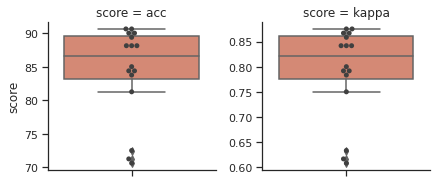

In [9]:
# Visualization
results = pd.read_csv(os.path.join(out_path,'results.csv'))
df = results.groupby(['subject']).mean().reset_index()
df = df.drop('fold', axis=1)
df = df.melt(value_vars=['acc', 'kappa'], var_name='score')

g = sns.FacetGrid(data=df, col='score', sharey=False)
g.map(sns.boxplot, 'value', orient='v')
g.map(sns.swarmplot, 'value', color='0.25', orient='v')
g.set_axis_labels('', 'score')